# Installation of a Python environment for The Virtual Brain (TVB)

To install The Virtual Brain, you can use the anaconda-navigator 'graphical user interface' (gui) using the yaml environment file named `environment_tvb.yml`.

Alternatively, you can use the command line (here for linux) as follows:
- create a conda environment named 'tvb' with the adequate python version: `conda create -n tvb python=3.11`  (say yes to prompt during installation)
- activate the environment: `conda activate tvb`
- install pip using conda: `conda install pip` (if not already installed) 
- install the package tvb using pip: `pip install tvb`
- install jupyter using conda: `conda install jupyter`
- install scikit-learn using conda: `conda install scikit-learn`

# Simulation of whole-brain neuronal network

This script is inspired by the preprint this preprint by [Breyton et al.](https://www.biorxiv.org/content/10.1101/2023.04.18.537321v1.full) as well as this tutorial based on the work by [Hansen et al.](https://nbviewer.thevirtualbrain.org/url/docs.thevirtualbrain.org/tutorials/tutorial_s5_ModelingRestingStateNetworks.ipynb). The TVB documentation is available [here](https://docs.thevirtualbrain.org/index.html).

We firstly load the network connectivity (human connectome) and normalize it to put all weight values within the interval $[0,1]$. See the corresponding [documentation page](https://docs.thevirtualbrain.org/manuals/UserGuide/UserGuide-UI_Connectivity.html) for further information.

In [1]:
import os, time

import numpy as np
import pandas as pd

import scipy.stats as stt

from tvb.simulator.lab import *
from tvb.simulator.backend.nb_mpr import NbMPRBackend

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedShuffleSplit

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sb

# ignore warning...

/home/INT/gilson.m/.local/lib/python3.10/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# load using TVB format
conn = connectivity.Connectivity().from_file(
    os.path.abspath('hcp-001.zip')
    #os.path.abspath('connectivity_76.zip')
)

# ignore warning....

2024-03-01 15:33:48,462 - WARNING - tvb.basic.readers - File 'average_orientations' not found in ZIP.
2024-03-01 15:33:48,464 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-03-01 15:33:48,464 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.


In [3]:
# normalization of the weights
conn.weights = np.log(np.maximum(conn.weights, conn.weights.max()*1e-4))
conn.weights /= conn.weights.max()

(array([3476.,  538.,  592.,  598.,  578.,  504.,  312.,  214.,  192.,
          52.]),
 array([-0.01527515,  0.08625236,  0.18777988,  0.28930739,  0.39083491,
         0.49236242,  0.59388994,  0.69541745,  0.79694497,  0.89847248,
         1.        ]),
 <BarContainer object of 10 artists>)

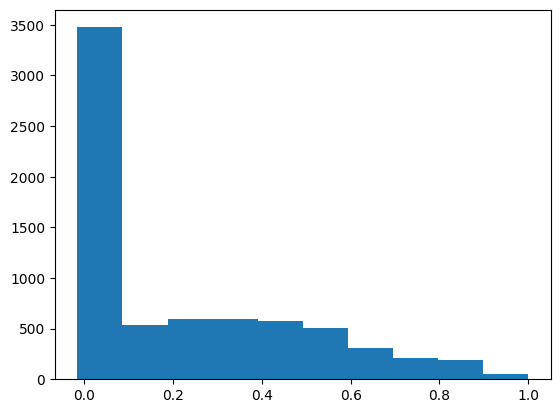

In [4]:
plt.hist(conn.weights.flatten())

You can plot the connectivity matrix, as well as check specific region labels and connection weights. Note that the matrix is symmetric here.

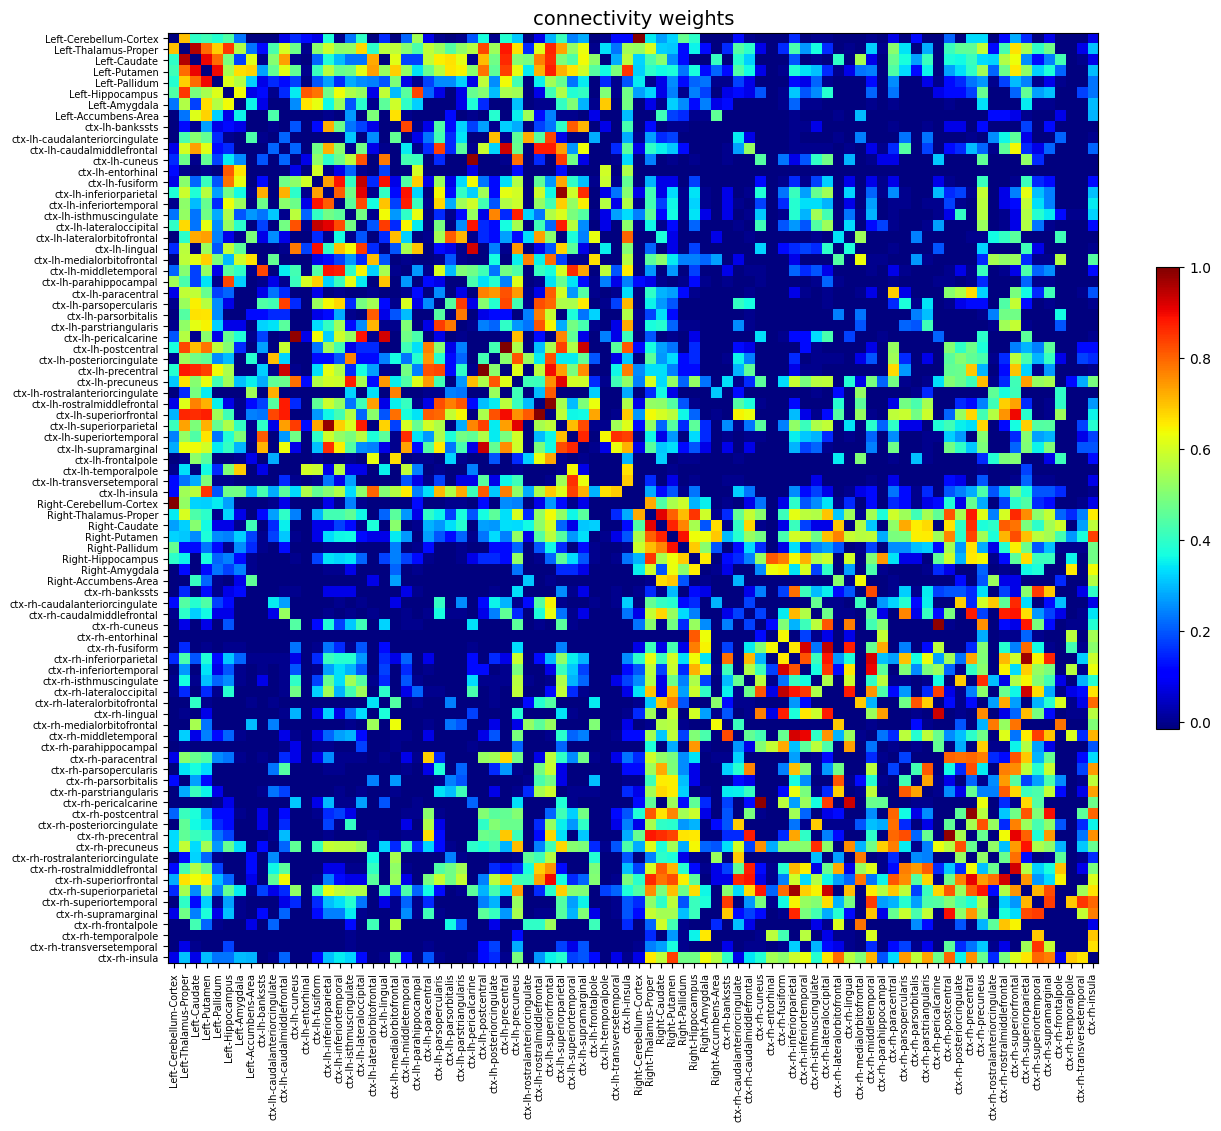

In [5]:
N = conn.region_labels.size

plt.figure(figsize=[15,15])
plt.imshow(conn.weights, interpolation='nearest', aspect='equal', cmap='jet')
plt.xticks(range(0, N), conn.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, N), conn.region_labels, fontsize=7)
plt.colorbar(shrink=0.4)
plt.title('connectivity weights', fontsize=14)
plt.show()

In [6]:
print('number of regions:', conn.number_of_regions)
print('region labels:', conn.region_labels) # here ctx stands for cortex, lh/rh for left/right hemisphere

number of regions: 0
region labels: ['Left-Cerebellum-Cortex' 'Left-Thalamus-Proper' 'Left-Caudate'
 'Left-Putamen' 'Left-Pallidum' 'Left-Hippocampus' 'Left-Amygdala'
 'Left-Accumbens-Area' 'ctx-lh-bankssts' 'ctx-lh-caudalanteriorcingulate'
 'ctx-lh-caudalmiddlefrontal' 'ctx-lh-cuneus' 'ctx-lh-entorhinal'
 'ctx-lh-fusiform' 'ctx-lh-inferiorparietal' 'ctx-lh-inferiortemporal'
 'ctx-lh-isthmuscingulate' 'ctx-lh-lateraloccipital'
 'ctx-lh-lateralorbitofrontal' 'ctx-lh-lingual'
 'ctx-lh-medialorbitofrontal' 'ctx-lh-middletemporal'
 'ctx-lh-parahippocampal' 'ctx-lh-paracentral' 'ctx-lh-parsopercularis'
 'ctx-lh-parsorbitalis' 'ctx-lh-parstriangularis' 'ctx-lh-pericalcarine'
 'ctx-lh-postcentral' 'ctx-lh-posteriorcingulate' 'ctx-lh-precentral'
 'ctx-lh-precuneus' 'ctx-lh-rostralanteriorcingulate'
 'ctx-lh-rostralmiddlefrontal' 'ctx-lh-superiorfrontal'
 'ctx-lh-superiorparietal' 'ctx-lh-superiortemporal'
 'ctx-lh-supramarginal' 'ctx-lh-frontalpole' 'ctx-lh-temporalpole'
 'ctx-lh-transversetem

In [7]:
i = 0
j = 1
print('weight between {} and {}: {}'.format(conn.region_labels[j], conn.region_labels[i], conn.weights[i,j]))

weight between Left-Thalamus-Proper and Left-Cerebellum-Cortex: 0.7025444196550777


# Simulation of Monbrio-Pazo-Roxin neuron network model

Following [the preprint](https://www.biorxiv.org/content/10.1101/2023.04.18.537321v1.full), we consider the Monbrio-Pazo-Roxin (MPR) neuronal model that we saw in the exercise. To run the MPR model efficiently in TVB, we need to use a specific backend with numba acceleration for the numerical simulation.

In [8]:
# wrapper function for 
def run_nbMPR_backend(sim, **kwargs):
    backend = NbMPRBackend()
    return backend.run_sim(sim, **kwargs)

A TVB simulation requires the definition of several model ingreddients:
- the neuronal model
- the network connectivity and the corresponding delay (or conduction speed here)
- the integration method for the differential equations
- the stimulus (possibly, here we simulate spontaneous activity also called resting state, without stimulus)

In [9]:
# MPR model with suitable default parameters
nrn_model = models.MontbrioPazoRoxin(
    eta   = np.r_[-5.0],
    J     = np.r_[15.],
    Delta = np.r_[1.],
)

In [10]:
# in addition to connectivity weights in conn, we specify the coupling (linear with scaling factor of 0.55) and conduction speed (uniform)
conn_coupling = coupling.Linear(
    a = np.array([0.06])
)

conn_speed = 20.0 # in ms

In [11]:
# noise variance on each node
nsigma = 0.03 # 0.001

# integrator for stochastic differential equation with small time step and random seed for pseudo number generation
integrator = integrators.HeunStochastic(
    dt=0.01,
    noise=noise.Additive(
        nsig=np.array([nsigma,nsigma*2,]), 
        noise_seed=int(time.time()))
)

In [12]:
monitor=[
    monitors.TemporalAverage(period=1.0) # 0.1, 1.0
]

Now we can run the simulation and calculate the functional connectivity (FC) of the simulated activity, as a measure to characterize the network dynamics. 

In [13]:
# perform the simulation for 1000 seconds
tic = time.time()
# configure the simulator
sim = simulator.Simulator(
    model=nrn_model,
    connectivity=conn,
    coupling=conn_coupling,
    conduction_speed=conn_speed,
    integrator=integrator,
    monitors=monitor,
    stimulus=None,
    initial_conditions=None
).configure()
# run and get simulation results
(v_time, v_act), = run_nbMPR_backend(sim, simulation_length=1000)

toc = time.time()
print('one simulation in %0.3f seconds.' % (toc-tic))

one simulation in 6.481 seconds.


In [14]:
print('time stamps of simulation (vector size / max):', v_time.size, ',', v_time.max())

time stamps of simulation (vector size / max): 1000 , 999.5


In [15]:
# get frate (1st variable) from monitored activity
v_act = np.squeeze(np.array(v_act[:,0,:]))

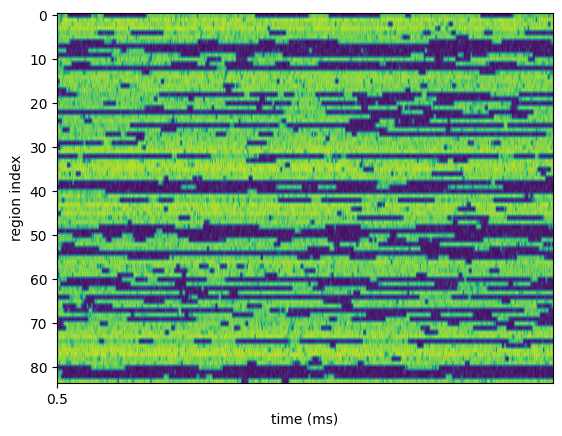

In [16]:
plt.figure()
plt.imshow(v_act.T, aspect='auto')
plt.xticks(range(0,v_time.size,1000), v_time[::1000])
plt.xlabel('time (ms)')
plt.ylabel('region index')
plt.show()

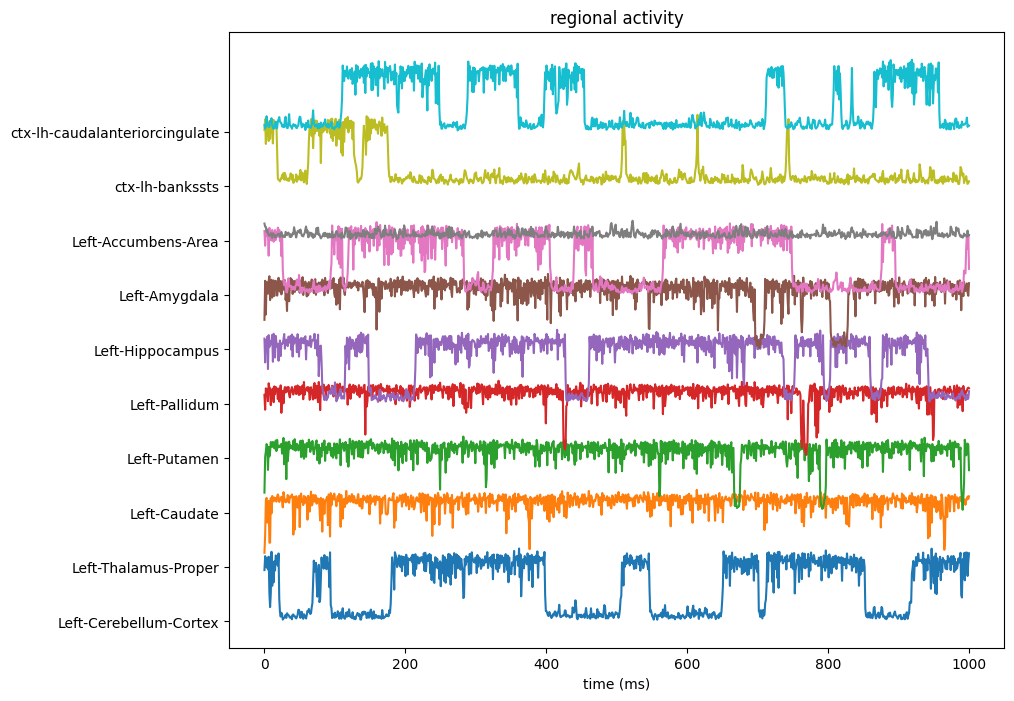

In [17]:
# Plot the time series
plt.figure(figsize=(10,8))
plt.plot(v_time[:], v_act[:, :10] + np.r_[:10])
plt.title('regional activity', fontsize=12)
plt.xlabel('time (ms)')
plt.yticks(range(10), conn.region_labels[:10], fontsize=10)
plt.show()

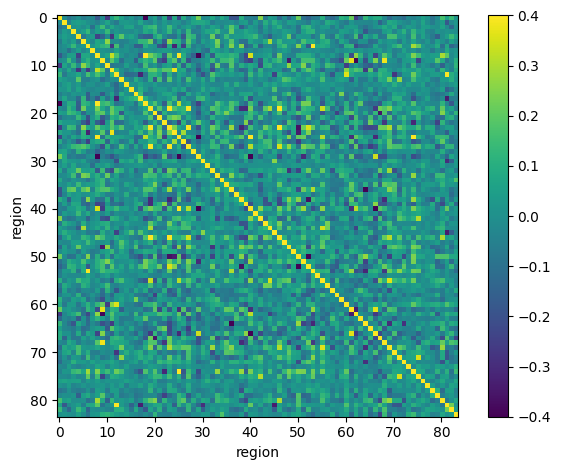

In [18]:
# calculate functional connectivity as correlation between activity time series
corr_act = np.corrcoef(v_act, rowvar=False)

plt.figure()
plt.imshow(corr_act, vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.xlabel('region')
plt.ylabel('region')
plt.tight_layout()
plt.show()

Let's plot the resulting FC as a function of the SC, to see the influence of the connectivity in the model onto the connectivity of the generated activity. It shows that strong anatomical weights don't necessary induce strong correlations for this dynamic network.

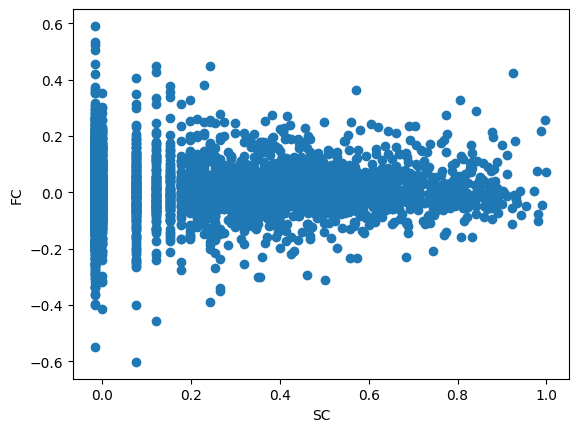

In [19]:
# mask for lower triangle (because of symmetricity)
mask_tri = np.tri(N,N,-1,dtype=bool)

plt.figure()
plt.scatter(conn.weights[mask_tri], corr_act[mask_tri])
plt.xlabel('SC')
plt.ylabel('FC')
plt.show()

We repeat the simulation 50 times to evaluate the trial-to-trial variability. We use principal component analysis (PCA) to represent the time series in reduced dimensionality.

Note that this can take quite some time depending on your computer...

In [20]:
n_rep = 25

# keep the lower triangle only of matrix because it is symmetric
ctrl_FC = np.zeros([n_rep,N,N])

# loop over repetitions
tic = time.time()
for i_rep in range(n_rep):
    print(i_rep)
    # run the simulation and get activity
    sim = simulator.Simulator(
        model=nrn_model,
        connectivity=conn,
        coupling=conn_coupling,
        conduction_speed=conn_speed,
        integrator=integrator,
        monitors=monitor,
        stimulus=None,
        initial_conditions=None
    ).configure()
    (v_time, v_act), = run_nbMPR_backend(sim, simulation_length=1000)
    v_act = np.squeeze(np.array(v_act[:,0,:]))
    # calculate FC
    corr_act = np.corrcoef(v_act, rowvar=False)
    # store simulated FC
    ctrl_FC[i_rep,:,:] = corr_act

toc = time.time()
print('{:d} simulation in {:0.3f} seconds.'.format(n_rep, toc-tic))

0
2024-03-01 15:33:56,781 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
1
2024-03-01 15:34:01,758 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2
2024-03-01 15:34:06,818 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
3
2024-03-01 15:34:11,828 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
4
2024-03-01 15:34:17,168 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
5
2024-03-01 15:34:22,088 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
6
2024-03-01 15:34:27,177 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
7
2024-03-01 15:34:32,536 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
8
2024-03-01 15:34:37,966 - ERROR - tvb.simulator.simulator - Bad Simulator.inte

Now we weaken all connections from and to a given region $i$ such as to simulate a brain network with a pathological degradation of connectivity. The goal is to check whether we can detect this structural alteration from the FC measure.

We can use the PCA visualization to see whether the alteration leads to a different distribution of FCs. To go further, one can use decoding with labels for the "control" and "pathological" conditions to see whether the structural alteration is reflected in the functional measure.

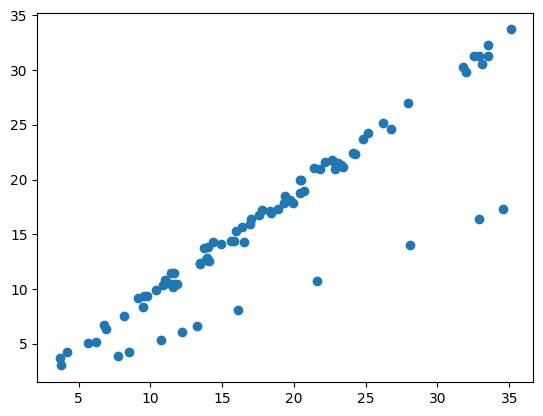

In [21]:
# list of affected nodes
ind_path = np.arange(10)

# copy original connectivity and create mask of weights to weaken
path_conn = conn.duplicate()
mask_path = np.zeros([N,N],dtype=bool)
for i in ind_path:
    mask_path[i,:] = True
    mask_path[:,i] = True
path_conn.weights[mask_path] *= 0.5 # weakening of connections


plt.scatter(conn.weights.sum(0),path_conn.weights.sum(0))

In [22]:
# rerun the simulations for the pathological connectome
path_FC = np.zeros([n_rep,N,N])

tic = time.time()
for i_rep in range(n_rep):
    print(i_rep)
    # run the simulation with new parameters and get activity
    path_sim = simulator.Simulator(
        model=nrn_model,
        connectivity=path_conn,
        coupling=conn_coupling,
        conduction_speed=conn_speed,
        integrator=integrator,
        monitors=monitor,
        stimulus=None,
        initial_conditions=None
    ).configure()
    (v_time, v_act), = run_nbMPR_backend(path_sim, simulation_length=1000)
    #(v_time, v_act), = path_sim.run(simulation_length=1000)
    v_act = np.squeeze(np.array(v_act[:,0,:]))
    # calculate FC
    corr_act = np.corrcoef(v_act, rowvar=False)
    # store simulated FC
    path_FC[i_rep,:,:] = corr_act

toc = time.time()
print('{:d} simulation in {:0.3f} seconds.'.format(n_rep, toc-tic))

0
2024-03-01 15:36:08,835 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
1
2024-03-01 15:36:13,828 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2
2024-03-01 15:36:18,896 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
3
2024-03-01 15:36:24,267 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
4
2024-03-01 15:36:29,399 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
5
2024-03-01 15:36:34,599 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
6
2024-03-01 15:36:39,931 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
7
2024-03-01 15:36:45,022 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
8
2024-03-01 15:36:50,127 - ERROR - tvb.simulator.simulator - Bad Simulator.inte

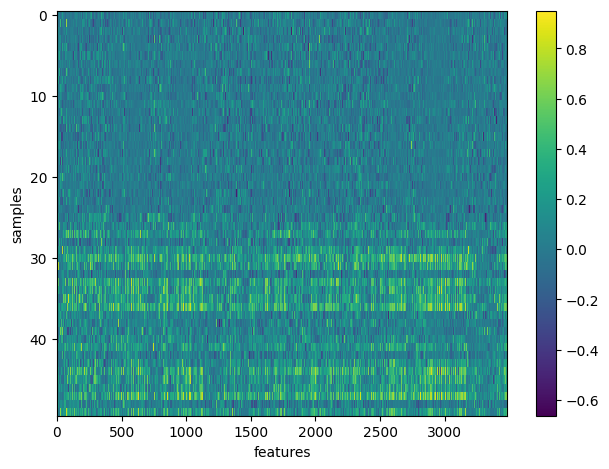

In [23]:
# group all samples (control and pathological) together
all_FC = np.concatenate((ctrl_FC,path_FC), axis=0)

# vectorize the FC matrices by keeping the lower triangle in each
X_FC = all_FC[:,mask_tri]

plt.figure()
plt.imshow(X_FC, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('features')
plt.ylabel('samples')
plt.tight_layout()
plt.show()

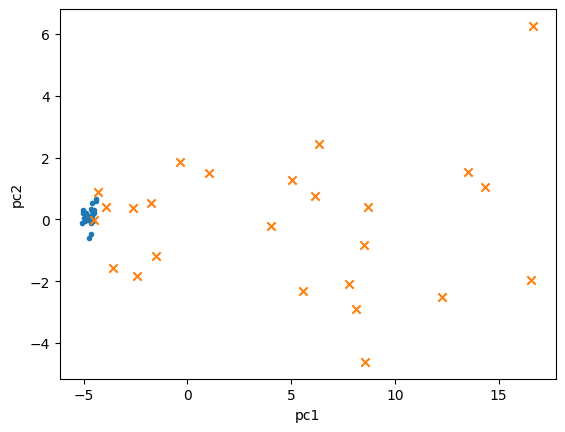

In [24]:
# PCA for all samples
pca = PCA(n_components=2)
pc_FC = pca.fit_transform(X_FC)

plt.figure()
plt.scatter(pc_FC[:n_rep,0], pc_FC[:n_rep,1], marker='.')
plt.scatter(pc_FC[n_rep:,0], pc_FC[n_rep:,1], marker='x')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

In [25]:
# classifier and cross-validation scheme
mlr = LogisticRegression(C=1.0, max_iter=500)

# number of splits for cross validation
n_split = 40

# function to perform the train-test data splits and evaluate the classification performance
def eval_classif(X, y, cv_seed=12345):
    acc = [] # test accuracy
    acc_shuf = [] # chance level counterpart
    
    # cross-validation scheme (to initialize the random state and have similar splits across metrics
    cv = StratifiedShuffleSplit(test_size=0.2, n_splits=n_split, random_state=cv_seed)

    # loop over train and test splits
    for train_idx, test_idx in cv.split(X, y):
        # test acuuracy for data
        mlr.fit(X[train_idx,:], y[train_idx])
        acc.append(mlr.score(X[test_idx,:], y[test_idx]))
        # chance level by shuffling
        perm_train_idx = np.random.permutation(train_idx)
        mlr.fit(X[train_idx,:], y[perm_train_idx])
        acc_shuf.append(mlr.score(X[test_idx,:], y[test_idx]))
    
    # returns the two lists of accuracies
    return acc, acc_shuf

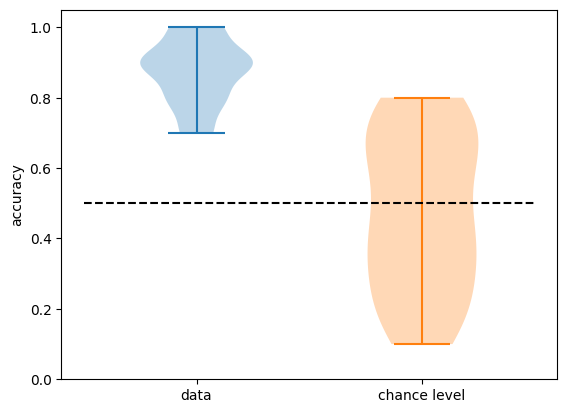

In [26]:
# labels for classification: 0 for controls, 1 for pathological
lbl = np.zeros([n_rep*2], dtype=int)
lbl[n_rep:] = 1

# test accuracy and chance level counterpart
acc_FC, acc_shuf_FC = eval_classif(X_FC, lbl)

plt.figure()
plt.violinplot(acc_FC, positions=[1])
plt.violinplot(acc_shuf_FC, positions=[2])
plt.plot([0.5,2.5], [0.5,0.5],'--k')
plt.xticks([1,2], ['data','chance level'])
plt.ylabel('accuracy')
plt.axis(ymin=0.0, ymax=1.05)
plt.show()

# Further tests with other metrics

FC strength is the sum of FC interaction values for each node. It is the equivalent metric for FC at the node level (while correlation values are at the interaction level). In this sense, we can compare the accuracy performance for the same information (FC) at two levels: interaction versus node. 

Note that a fair comparison between different measures should have the same train-test splits, so the function `eval_classif` has the same `cv_seed` by default.

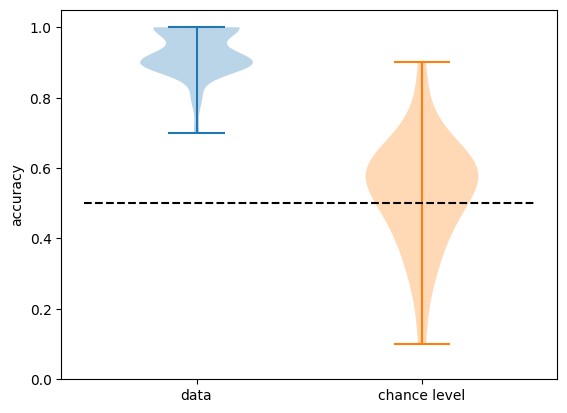

In [27]:
# FC strength = sum of FC values for each node
X_FCstrengh = all_FC.sum(axis=2)

# test accuracy and chance level counterpart
acc_FCs, acc_shuf_FCs = eval_classif(X_FCstrengh, lbl)

plt.figure()
plt.violinplot(acc_FCs, positions=[1])
plt.violinplot(acc_shuf_FCs, positions=[2])
plt.plot([0.5,2.5], [0.5,0.5],'--k')
plt.xticks([1,2], ['data','chance level'])
plt.ylabel('accuracy')
plt.axis(ymin=0.0, ymax=1.05)
plt.show()

In addition, we can also use a graph measure from the FC matrix. Here we rely on the eigenvector centrality applied to each full weighted matrix with FC values (correlations between regional activities). Recall that the eigenvector centrality extends the FC strength in giving a value per node that takes the whole network into account, beyond directly connected neighbors here. Note that here, since FC is a full matrix, for each node all remaining nodes are neighbors.

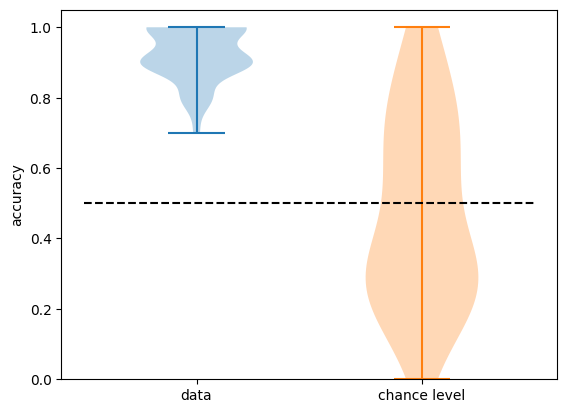

In [28]:
# eigenvector centrality for graph built from each FC matrix
X_eigcent = np.zeros([n_rep*2,N])
for i_rep in range(n_rep*2):
    G = nx.from_numpy_array(all_FC[i_rep,:,:])
    dict_ec = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
    X_eigcent[i_rep,:] = [v for v in dict_ec.values()]

# test accuracy and chance level counterpart
acc_ec, acc_shuf_ec = eval_classif(X_eigcent, lbl)

plt.figure()
plt.violinplot(acc_ec, positions=[1])
plt.violinplot(acc_shuf_ec, positions=[2])
plt.plot([0.5,2.5], [0.5,0.5],'--k')
plt.xticks([1,2], ['data','chance level'])
plt.ylabel('accuracy')
plt.axis(ymin=0.0, ymax=1.05)
plt.show()

Another option is to binarize the FC matrix and build a binary graph from it, resulting in a network of interactions for highly correlated regions. Here we simply take the degree of the resulting network for each sample.

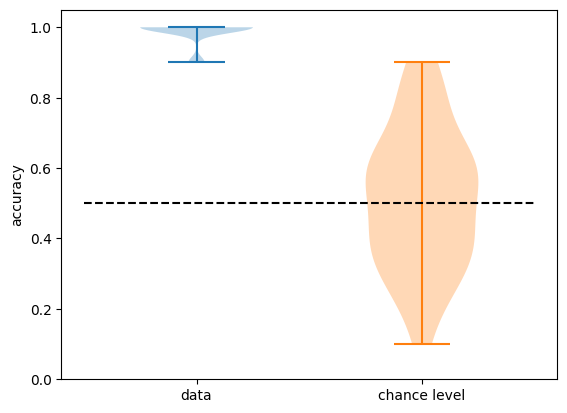

In [29]:
# eigenvector centrality for graph made from interactions corresponding to high correlations (in absolute value)
X_deg = np.zeros([n_rep*2,N])
for i_rep in range(n_rep*2):
    bin_FC = np.array(np.abs(all_FC[i_rep,:,:])>0.2, dtype=int)
    G = nx.from_numpy_array(bin_FC)
    dict_deg = nx.degree(G)
    X_deg[i_rep,:] = [v for _,v in dict_deg]

# test accuracy and chance level counterpart
acc_deg, acc_shuf_deg = eval_classif(X_deg, lbl)

plt.figure()
plt.violinplot(acc_deg, positions=[1])
plt.violinplot(acc_shuf_deg, positions=[2])
plt.plot([0.5,2.5], [0.5,0.5],'--k')
plt.xticks([1,2], ['data','chance level'])
plt.ylabel('accuracy')
plt.axis(ymin=0.0, ymax=1.05)
plt.show()

Last, we calculate the communities for each FC graph (not binarized) and build a "community matrix" where pairs of nodes in the same community correspond to an element equal to $1$ in the matrix, and $0$ otherwise; note that self-interactions are forced to $0$.

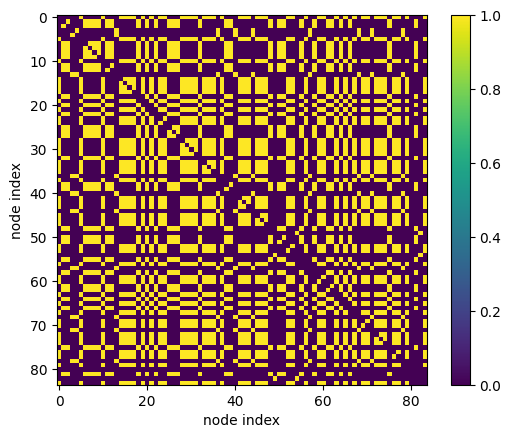

In [30]:
# example of community matrix
G = nx.from_numpy_array(all_FC[i_rep,:,:])
list_comm = nx.community.greedy_modularity_communities(G, weight='weight')
M = np.zeros([N,N])
for gp in list_comm:
    for i in gp:
        for j in gp:
            if i!=j: # except when i==j
                M[i,j] = 1.0
            
plt.figure()
plt.imshow(M)
plt.colorbar()
plt.xlabel('node index')
plt.ylabel('node index')
plt.show()

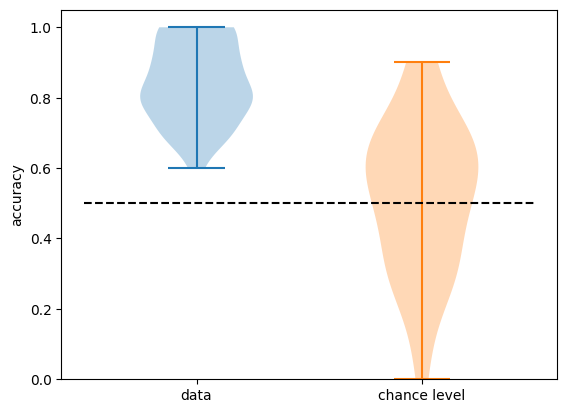

In [31]:
# eigenvector centrality for graph made with 
X_comm = np.zeros([n_rep*2,mask_tri.sum()])
for i_rep in range(n_rep*2):
    G = nx.from_numpy_array(all_FC[i_rep,:,:])
    list_comm = nx.community.greedy_modularity_communities(G, weight='weight')
    M = np.zeros([N,N])
    for gp in list_comm:
        for i in gp:
            for j in gp:
                if i!=j: # except when i==j
                    M[i,j] = 1.0
    X_comm[i_rep,:] = M[mask_tri]

# test accuracy and chance level counterpart
acc_comm, acc_shuf_comm = eval_classif(X_comm, lbl)

plt.figure()
plt.violinplot(acc_comm, positions=[1])
plt.violinplot(acc_shuf_comm, positions=[2])
plt.plot([0.5,2.5], [0.5,0.5],'--k')
plt.xticks([1,2], ['data','chance level'])
plt.ylabel('accuracy')
plt.axis(ymin=0.0, ymax=1.05)
plt.show()

# Comparison of all decoding performances

We first test whether the chance level accuracies are comparable; to do so we use a Wilcoxon signed test to see whether there is a significant difference between the distribution of values (as accuracies come from the same train-test splits). Then we plot the test accuracies together for visual comparison.

In [32]:
list_tag = ['FC', 'FC str', 'eig cent', 'degree', 'comm']
list_acc = [acc_FC, acc_FCs, acc_ec, acc_deg, acc_comm]
list_acc_shuf = [acc_shuf_FC, acc_shuf_FCs, acc_shuf_ec, acc_shuf_deg, acc_shuf_comm]

df = pd.DataFrame()
for tag, acc, acc_shuf in zip(list_tag, list_acc, list_acc_shuf):
    # build data frame with accuracies (test and shuf)
    df2 = pd.DataFrame()
    df2['type'] = [tag]*n_split
    df2['acc'] = acc
    df2['acc_shuf'] = acc_shuf
    # concatenate with previous data frame
    df = pd.concat((df,df2), ignore_index=True)

In [33]:
# test for no significant difference between shuffle accuracies (p-values should be above 0.05)
k = len(list_acc_shuf)
for i in range(k):
    for j in range(i):
        as_i = list_acc_shuf[i]
        as_j = list_acc_shuf[j]
        print(stt.wilcoxon(as_i, as_j, alternative='two-sided'))

WilcoxonResult(statistic=281.5, pvalue=0.2900355644631082)
WilcoxonResult(statistic=349.0, pvalue=0.9698877905769129)
WilcoxonResult(statistic=230.0, pvalue=0.3663862873781556)
WilcoxonResult(statistic=284.5, pvalue=0.4457169907535593)
WilcoxonResult(statistic=313.0, pvalue=0.7525614099504168)
WilcoxonResult(statistic=319.0, pvalue=0.45444900625873996)
WilcoxonResult(statistic=299.0, pvalue=0.4276390156303139)
WilcoxonResult(statistic=273.5, pvalue=0.6804574822984693)
WilcoxonResult(statistic=295.0, pvalue=0.3933118310015302)
WilcoxonResult(statistic=331.0, pvalue=0.9748372550650248)


/home/INT/gilson.m/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


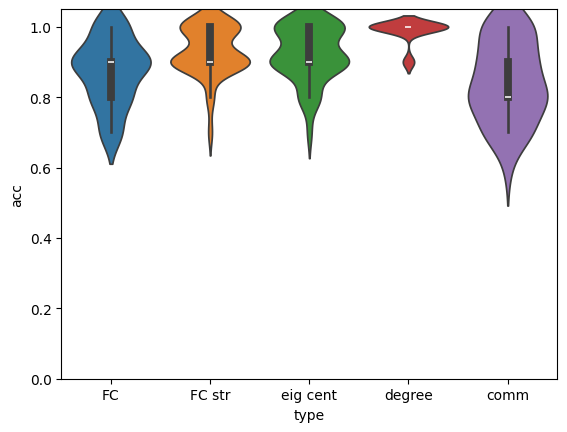

In [34]:
plt.figure()
sb.violinplot(data=df, y='acc', x='type', hue='type', density_norm='width')
plt.axis(ymin=0.0, ymax=1.05)

plt.show()

We see that the different measures yield distinct performance, which we can quantitatively test using the Wilcoxon test again. This shows that, depending on the data, some graph metric might better extract information that original information (FC values). Here its seems that the binarized degree works best, but you should check whether this is robust to changing the random seed for the train-test splitting...

**BUT** in any case, remember that each dataset is independent and that this is just an example, not a general observation of which metric is the best *for all datasets*.

In [35]:
# test whether accuracies for a metric are greater than another:
# the statistical "answer" is yes when the p-value is smaller than 0.05
k = len(list_acc)
for i in range(k):
    print()
    for j in range(k):
        if i!=j:
            as_i = list_acc[i]
            as_j = list_acc[j]
            print('{} better than {}: '.format(list_tag[i], list_tag[j]),
                  stt.wilcoxon(as_i, as_j, alternative='greater'))


FC better than FC str:  WilcoxonResult(statistic=0.0, pvalue=0.9999096369165024)
FC better than eig cent:  WilcoxonResult(statistic=27.0, pvalue=0.9996873258124187)
FC better than degree:  WilcoxonResult(statistic=0.0, pvalue=0.9999992572338079)
FC better than comm:  WilcoxonResult(statistic=289.0, pvalue=0.020206236682013417)

FC str better than FC:  WilcoxonResult(statistic=153.0, pvalue=9.036308349764196e-05)
FC str better than eig cent:  WilcoxonResult(statistic=110.0, pvalue=0.24564856210794656)
FC str better than degree:  WilcoxonResult(statistic=0.0, pvalue=0.9999884558231437)
FC str better than comm:  WilcoxonResult(statistic=458.0, pvalue=9.768889603421348e-05)

eig cent better than FC:  WilcoxonResult(statistic=226.0, pvalue=0.0003126741875813212)
eig cent better than FC str:  WilcoxonResult(statistic=80.0, pvalue=0.7543514378920535)
eig cent better than degree:  WilcoxonResult(statistic=0.0, pvalue=0.9999787028650554)
eig cent better than comm:  WilcoxonResult(statistic=292

/home/INT/gilson.m/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
